
# MTH3302 : Méthodes probabilistes et statistiques pour l'I.A.

Jonathan Jalbert<br/>
Professeur adjoint au Département de mathématiques et de génie industriel<br/>
Polytechnique Montréal<br/>

Le projet a été développé à l'aide de Alice Breton, étudiante à la maîtrise en génie informatique. Elle a suivi le cours lors de la session Hiver 2019.



# Projet : Débordement d'égouts

La description du projet est disponible à l'adresse suivante :
https://www.kaggle.com/t/a238b752c33a41d9803c2cdde6bfc929

Ce calepin Jupyter de base permet de charger et de nettoyer les données fournies. La dernière section détaille la génération du fichier des prédictions afin de le soumettre sur Kaggle dans le bon format.

Dans un premier temps, vous devrez récupérer l'archive *data.zip* sur Moodle. Ce dossier contient les fichiers suivants :
- surverses.csv
- precipitation.csv
- ouvrages-surverses.csv
- test.csv

Veuillez le décompresser dans le répertoire de ce calepin.

Le fichier *surverse.csv* répertorie s'il y a surverse (1) ou non (0) au cours de la journée pour les 170 ouvrages de débordement de 2013 à 2018 pour les mois de mai à octobre (inclusivement). Des renseignements additionnels sur les données sont disponibles à l'adresse suivante :

http://donnees.ville.montreal.qc.ca/dataset/debordement


Le fichier *precipitation.csv* contient les précipitations horaires en dixième de *mm* enregistrées à 5 stations pluviométriques de 2013 à 2019 :
- McTavish (7024745)
- Ste-Anne-de-Bellevue (702FHL8)
- Montreal/Pierre Elliott Trudeau Intl (702S006)
- Montreal/St-Hubert (7027329)
- L’Assomption (7014160)

Plus d'informations sur les précipitations sont disponibles à l'adresse suivante :

https://climat.meteo.gc.ca/climate_data/hourly_data_f.html?hlyRange=2008-01-08%7C2019-11-12&dlyRange=2002-12-23%7C2019-11-12&mlyRange=%7C&StationID=30165&Prov=QC&urlExtension=_f.html&searchType=stnName&optLimit=yearRange&StartYear=1840&EndYear=2019&selRowPerPage=25&Line=17&searchMethod=contains&Month=11&Day=12&txtStationName=montreal&timeframe=1&Year=2019

Le fichier *ouvrages-surverses.csv* contient différentes caractéristiques des ouvrages de débordement. 

http://donnees.ville.montreal.qc.ca/dataset/ouvrage-surverse

Le fichier *test.csv* contient les ouvrages et les jours pour lesquels vous devez prédire s'il y a eu surverse (true) ou non (false). Notez que l'on s'intéresse ici à 5 ouvrages de débordement localisés tout autour de l'Ile de Montréal :
- 3260-01D dans Rivière-des-Prairies 
- 3350-07D dans Ahunstic 
- 4240-01D dans Pointe-aux-Trembles 
- 4350-01D dans le Vieux-Montréal 
- 4380-01D dans Verdun

#### Remarque

Dans le projet, on ne s'intéresse qu'aux surverses occasionnées par les précipitations. On ignore les surverses occasionnées par 
- fonte de neige (F)
- travaux planifiés et entretien (TPL)
- urgence (U)
- autre (AUT)

On suppose que lorsqu'il n'y a pas de raison pour la surverse, il s'agit d'une surverse causée par les précipitations. Puisque Nous nous intéresserons uniquement aux surverses occasionnées par les précipitations liquides, nous ne considérons que les mois de mai à octobre inclusivement.

In [9]:
using CSV, DataFrames, Statistics, Dates, Gadfly, LinearAlgebra, Random
using ScikitLearn, DecisionTree

@sk_import decomposition: PCA
@sk_import linear_model: LogisticRegression
@sk_import preprocessing: StandardScaler
@sk_import model_selection: (train_test_split, RandomizedSearchCV, GridSearchCV)
@sk_import metrics: (classification_report, roc_auc_score, auc, make_scorer, f1_score)
# @sk_import model_selection: train_test_split



#, GLM,Distributions,
include("functions.jl");

# Chargement des données et nettoyage préliminaire

## Chargement et nettoyage des surverses et précipitations

In [10]:
data = CSV.read("data/surverses.csv",missingstring="-99999")
first(data,5)

# Extraction des surverses pour les mois de mai à octobre inclusivement
data = filter(row -> month(row.DATE) > 4, data) 
data = filter(row -> month(row.DATE) < 11, data) 

# Remplacement des valeurs *missing* dans la colonne :RAISON par "Inconnue"
raison = coalesce.(data[:,:RAISON],"Inconnue")
data[!,:RAISON] = raison

# Exlusion des surverses coccasionnées par d'autres facteurs que les précipitations liquides
data = filter(row -> row.RAISON ∈ ["P","Inconnue","TS"], data) 
select!(data, [:NO_OUVRAGE, :DATE, :SURVERSE])

surverse_df = dropmissing(data, disallowmissing=true)

### CHARGEMENT DES PRÉCIPITATIONS
data = CSV.read("data/precipitations.csv",missingstring="-99999")
rename!(data, Symbol("St-Hubert")=>:StHubert)

# Nettoyage des données sur les précipitations
data = filter(row -> month(row.date) > 4, data) 
data = filter(row -> month(row.date) < 11, data);


# Remplissage des valeurs de précipitations manquantes.

### Nous remplaçons les données manquantes grâce à une simple régression linéaire (Ridge). Pour ce faire, chaque station météo agira comme variable explicative pour les 4 autres. On drop les rangées pour lesquelles les 5 valeurs sont manquantes.

In [105]:
data_full = deepcopy(data)
dropmissing!(data, disallowmissing=true)

models = Dict()

for i = 1:length(data_full[:, 1])
    if any(ismissing, data_full[i, 3:7])
        missing = []
        notmissing = []
        for j=3:7
            if ismissing(data_full[i, j])
                push!(missing, names(data_full)[j])
            else
                push!(notmissing, names(data_full)[j])
            end
        end
        
        if length(notmissing) > 0
            for m in missing
                if !haskey(models, (m, notmissing))
                    models[(m, notmissing)] = CoeffRidge(data, m, notmissing)
                end
                data_full[i, m] = round(convert(Vector{Float64}, data_full[i, notmissing])' * models[(m, notmissing)])
            end
        end
    end
end

dropmissing!(data_full);



## Extraction variables explicatives

In [95]:
# Maximum de précipitations en 1 heure dans une journée.
X_pcp_max = by(data_full, :date,  MAXMcTavish = :McTavish=>maximum, MAXBellevue = :Bellevue=>maximum, 
   MAXAssomption = :Assomption=>maximum, MAXTrudeau = :Trudeau=>maximum, MAXStHubert = :StHubert=>maximum)

# Somme des précipitations dans une journée
X_pcp_sum = by(data_full, :date,  SUMMcTavish = :McTavish=>sum, SUMBellevue = :Bellevue=>sum, 
   SUMAssomption = :Assomption=>sum, SUMTrudeau = :Trudeau=>sum, SUMStHubert = :StHubert=>sum)

# Somme des précipitations des 2 heures précédentes
X_pcp_three_hours = copy(data_full)
buffer = copy(data_full)
for i=3:7
    for j=1:length(data_full[:,2])
        if (j > 2)
            X_pcp_three_hours[j, i] = (buffer[(j-2), i] + buffer[(j-1), i] + buffer[j,i])
        else
            X_pcp_three_hours[j, i] = buffer[j, i]
        end
    end
end

# Somme des précipitations des 2 jours précédents
X_pcp_two_days = DataFrame(date= X_pcp_sum[:,:date], SUM2DaysMcTavish=zeros(Int64, length(X_pcp_sum[:,1])), SUM2DaysBellevue=zeros(Int64, length(X_pcp_sum[:,1])), SUM2DaysAssomption=zeros(Int64, length(X_pcp_sum[:,1])), SUM2DaysTrudeau=zeros(Int64, length(X_pcp_sum[:,1])), SUM2DaysStHubert=zeros(Int64, length(X_pcp_sum[:,1])))
#buffer = copy(X_pcp_sum)
for i=2:6
    for j=1:length(X_pcp_two_days[:,1])
        if (j > 1)
            X_pcp_two_days[j, i] = X_pcp_sum[(j-1), i] + X_pcp_sum[j,i]
        else
            X_pcp_two_days[j, i] = X_pcp_sum[j, i]
        end
    end
end

# Moyenne des précipitations par jour
X_pcp_mean = by(data_full, :date,  MEANMcTavish = :McTavish=>mean, MEANBellevue = :Bellevue=>mean, 
            MEANAssomption = :Assomption=>mean, MEANTrudeau = :Trudeau=>mean, MEANStHubert = :StHubert=>mean)


# Maximum de précipitations tombées en 3 heures dans une journée
X_max_three_hours = by(X_pcp_three_hours, :date, MAX3HMcTavish = :McTavish=>findmax, MAX3HBellevue = :Bellevue=>findmax, 
    MAX3HAssomption = :Assomption=>findmax, MAX3HTrudeau = :Trudeau=>findmax, MAX3HStHubert = :StHubert=>findmax)
 



1287×6 DataFrame. Omitted printing of 2 columns
│ Row  │ date       │ MAX3HMcTavish │ MAX3HBellevue │ MAX3HAssomption │
│      │ Date       │ Tuple…        │ Tuple…        │ Tuple…          │
├──────┼────────────┼───────────────┼───────────────┼─────────────────┤
│ 1    │ 2013-05-01 │ (0, 1)        │ (0, 1)        │ (0, 1)          │
│ 2    │ 2013-05-02 │ (0, 1)        │ (0, 1)        │ (0, 1)          │
│ 3    │ 2013-05-03 │ (0, 1)        │ (0, 1)        │ (0, 1)          │
│ 4    │ 2013-05-04 │ (0, 1)        │ (0, 1)        │ (0, 1)          │
│ 5    │ 2013-05-05 │ (0, 1)        │ (0, 1)        │ (0, 1)          │
│ 6    │ 2013-05-06 │ (0, 1)        │ (0, 1)        │ (0, 1)          │
│ 7    │ 2013-05-07 │ (0, 1)        │ (0, 1)        │ (0, 1)          │
│ 8    │ 2013-05-08 │ (0, 1)        │ (0, 1)        │ (0, 1)          │
│ 9    │ 2013-05-09 │ (10, 7)       │ (0, 1)        │ (19, 14)        │
│ 10   │ 2013-05-10 │ (0, 1)        │ (4, 23)       │ (20, 24)        │
⋮
│ 1277 │ 2019-10-20 │ (0, 1)        │ (0, 1)        │ (0, 1)          │
│ 1278 │ 2019-10-21 │ (0, 1)        │ (0, 1)        │ (0, 1)          │
│ 1279 │ 2019-10-22 │ (76, 24)      │ (62, 24)      │ (39, 24)        │
│ 1280 │ 2019-10-23 │ (122, 3)      │ (79, 2)       │ (61, 2)         │
│ 1281 │ 2019-10-24 │ (0, 1)        │ (0, 1)        │ (0, 1)          │
│ 1282 │ 2019-10-25 │ (0, 1)        │ (0, 1)        │ (0, 1)          │
│ 1283 │ 2019-10-26 │ (0, 1)        │ (0, 1)        │ (0, 1)          │
│ 1284 │ 2019-10-27 │ (210, 13)     │ (141, 13)     │ (102, 13)       │
│ 1285 │ 2019-10-28 │ (4, 1)        │ (2, 10)       │ (2, 1)          │
│ 1286 │ 2019-10-29 │ (0, 1)        │ (0, 1)        │ (0, 1)          │
│ 1287 │ 2019-10-30 │ (0, 1)        │ (0, 1)        │ (0, 1)          │

In [125]:
"""
CreateDataFrame crée un dataframe contenant toutes les variables explicatives ainsi que l'occurence 
des surverses pour un ouvrage donné.

@params
ouvrage: sigle de l'ouvrage d'intérêt.
surverse_df: dataframe des surverses selon la date.

df_train: dataframe contenant toutes les variables explicatives ainsi que l'occurence ou non de surverses.

"""
function CreateDataframe(ouvrage, surverse_df)
    df_train = filter(row -> row.NO_OUVRAGE == ouvrage, surverse_df)

    x₁ = Array{Int64}(undef, size(df_train,1)) # variable pour la somme journalière McTavish
    x₂ = Array{Int64}(undef, size(df_train,1)) # variable pour la somme journalière Bellevue
    x₃ = Array{Int64}(undef, size(df_train,1)) # variable pour la somme journalière Assomption
    x₄ = Array{Int64}(undef, size(df_train,1)) # variable pour la somme journalière PET
    x₅ = Array{Int64}(undef, size(df_train,1)) # variable pour la somme journalière St-Hubert
    x₆ = Array{Int64}(undef, size(df_train,1)) # variable pour la somme des 2 jours McTavish
    x₇ = Array{Int64}(undef, size(df_train,1)) # variable pour la somme des 2 jours Bellevue
    x₈ = Array{Int64}(undef, size(df_train,1)) # variable pour la somme des 2 jours Assomption
    x₉ = Array{Int64}(undef, size(df_train,1)) # variable pour la somme des 2 jours PET
    x₁₀ = Array{Int64}(undef, size(df_train,1)) # variable pour la somme des 2 jours St-Hubert
    x₁₁ = Array{Int64}(undef, size(df_train,1)) # variable pour le max journalier McTavish
    x₁₂ = Array{Int64}(undef, size(df_train,1)) # variable pour le max journalier Bellevue
    x₁₃ = Array{Int64}(undef, size(df_train,1)) # variable pour le max journalier Assomption
    x₁₄ = Array{Int64}(undef, size(df_train,1)) # variable pour le max journalier PET
    x₁₅ = Array{Int64}(undef, size(df_train,1)) # variable pour le max journalier St-Hubert
    x₁₆ = Array{Int64}(undef, size(df_train,1)) # variable pour le max par bloc de 3h McTavish
    x₁₇ = Array{Int64}(undef, size(df_train,1)) # variable pour le max par bloc de 3h Bellevue
    x₁₈ = Array{Int64}(undef, size(df_train,1)) # variable pour le max par bloc de 3h Assomption
    x₁₉ = Array{Int64}(undef, size(df_train,1)) # variable pour le max par bloc de 3h PET
    x₂₀ = Array{Int64}(undef, size(df_train,1)) # variable pour le max par bloc de 3h St-Hubert
    x₂₁ = Array{Float64}(undef, size(df_train,1)) # variable pour la moyenne des précipitations pour McTavish 
    x₂₂ = Array{Float64}(undef, size(df_train,1)) # variable pour la moyenne des précipitations pour Bellevue
    x₂₃ = Array{Float64}(undef, size(df_train,1)) # variable pour la moyenne des précipitations pour Assomption
    x₂₄ = Array{Float64}(undef, size(df_train,1)) # variable pour la moyenne des précipitations pour PET
    x₂₅ = Array{Float64}(undef, size(df_train,1)) # variable pour la moyenne des précipitations pour St-Hubert
        
    for i=1:size(df_train,1)

        ind = findfirst(X_pcp_sum[:,:date] .== df_train[i,:DATE])
        
        x₁[i] = X_pcp_sum[ind,:SUMMcTavish]

        x₂[i] = X_pcp_sum[ind,:SUMBellevue]

        x₃[i] = X_pcp_sum[ind,:SUMAssomption]

        x₄[i] = X_pcp_sum[ind,:SUMTrudeau]

        x₅[i] = X_pcp_sum[ind,:SUMStHubert]
        
        ind = findfirst(X_pcp_two_days[:,:date] .== df_train[i,:DATE])

        x₆[i] = X_pcp_two_days[ind, :SUM2DaysMcTavish]

        x₇[i] = X_pcp_two_days[ind, :SUM2DaysBellevue]

        x₈[i] = X_pcp_two_days[ind, :SUM2DaysAssomption]

        x₉[i] = X_pcp_two_days[ind, :SUM2DaysTrudeau]

        x₁₀[i] = X_pcp_two_days[ind, :SUM2DaysStHubert]
        
        ind = findfirst(X_pcp_max[:,:date] .== df_train[i,:DATE])

        x₁₁[i] = X_pcp_max[ind, :MAXMcTavish]

        x₁₂[i] = X_pcp_max[ind, :MAXBellevue]

        x₁₃[i] = X_pcp_max[ind, :MAXAssomption]

        x₁₄[i] = X_pcp_max[ind, :MAXTrudeau]

        x₁₅[i] = X_pcp_max[ind, :MAXStHubert]
        
        ind = findfirst(X_max_three_hours[:,:date] .== df_train[i,:DATE])
        
        x₁₆[i] = X_max_three_hours[ind, :MAX3HMcTavish][1]
        
        x₁₇[i] = X_max_three_hours[ind, :MAX3HBellevue][1]
        
        x₁₈[i] = X_max_three_hours[ind, :MAX3HAssomption][1]
        
        x₁₉[i] = X_max_three_hours[ind, :MAX3HTrudeau][1]
        
        x₂₀[i] = X_max_three_hours[ind, :MAX3HStHubert][1]
        
        ind = findfirst(X_pcp_mean[:,:date] .== df_train[i,:DATE])
        
        x₂₁[i] = X_pcp_mean[ind, :MEANMcTavish]
        
        x₂₂[i] = X_pcp_mean[ind, :MEANBellevue]
        
        x₂₃[i] = X_pcp_mean[ind, :MEANAssomption]
        
        x₂₄[i] = X_pcp_mean[ind, :MEANTrudeau]
        
        x₂₅[i] = X_pcp_mean[ind, :MEANStHubert]
        
    end

    df_train[!, :SUMMcTavish] = x₁
    df_train[!, :SUMBellevue] = x₂
    df_train[!, :SUMAssomption] = x₃
    df_train[!, :SUMStHubert] = x₄
    df_train[!, :SUMPET] = x₅
    df_train[!, :SUM2McTavish] = x₆
    df_train[!, :SUM2Bellevue] = x₇
    df_train[!, :SUM2Assomption] = x₈
    df_train[!, :SUM2StHubert] = x₉
    df_train[!, :SUM2PET] = x₁₀
    df_train[!, :MAXMcTavish] = x₁₁
    df_train[!, :MAXBellevue] = x₁₂
    df_train[!, :MAXAssomption] = x₁₃
    df_train[!, :MAXStHubert] = x₁₄
    df_train[!, :MAXPET] = x₁₅
    df_train[!, :MAX3HMcTavish] = x₁₆
    df_train[!, :MAX3HBellevue] = x₁₇
    df_train[!, :MAX3HAssomption] = x₁₈
    df_train[!, :MAX3HTrudeau] = x₁₉
    df_train[!, :MAX3HStHubert] = x₂₀
    df_train[!, :MEANMcTavish] = x₂₁
    df_train[!, :MEANBellevue] = x₂₂
    df_train[!, :MEANAssomption] = x₂₃
    df_train[!, :MEANTrudeau] = x₂₄
    df_train[!, :MEANStHubert] = x₂₅
       
    return df_train

end


CreateDataframe

# Analyse exploratoire

Cette section consitue une analyse exploratoire permettant de voir s'il existe un lien entre l'occurence des surverses et les variables explicatives que nous avons extraites, c'est-à-dire:
- la somme journalière des précipitations
- le taux horaire maximum journalier de précipitations
- la somme des précipitations sur les deux jours précédents
- le maximum de la somme des précipitations sur une période de 3 heures dans une journée 
- la moyenne de précipitations journalières

**Noter** qu'afin d'alléger le calepin, nous ne présentons pas des graphiques pour les données provenant de chacune des stations météorologiques pour les cinq ouvrages. Nous ne présentons que les données des cinq stations pour un seul ouvrage, mais les tendances étaient très semblables d'un ouvrage à l'autre et ce, pour toutes les variables explicatives.

## Analyse de la somme journalière des précipitations

#### Boxplot de la somme journalière de précipitations de chaque station en fonction de l'occurence de surverse à l'ouvrage Rivières-des-Prairies
Ci-dessus la distribution de la somme journalière de précipitation aux différentes stations selon l'occurence ou non de surverse à l'ouvrage 3260 (**Rivière-des-Prairies**). La différence entre les deux distributions pour chaque station suggère que la somme journalière de précipitation observée à chaque station a une influence sur l'occurence des surverses à l'ouvrage 3260.

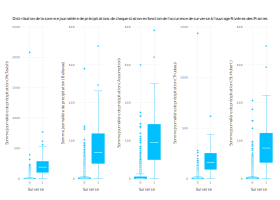

In [70]:
Gadfly.set_default_plot_size(28cm, 20cm)

df_3260 = CreateDataframe("3260-01D", surverse_df)
plot_3260_1 = plot(x=df_3260[:, :SURVERSE], y=df_3260[:, :SUMMcTavish], Geom.boxplot, Guide.xticks(ticks=[0, 1]), Guide.xlabel("Surverse"), Guide.ylabel("Somme journalière de précipitation (McTavish)", orientation=:vertical))
plot_3260_2 = plot(x=df_3260[:, :SURVERSE], y=df_3260[:, :SUMBellevue], Geom.boxplot, Guide.xticks(ticks=[0, 1]), Guide.xlabel("Surverse"), Guide.ylabel("Somme journalière de précipitation (Bellevue)", orientation=:vertical))
plot_3260_3 = plot(x=df_3260[:, :SURVERSE], y=df_3260[:, :SUMAssomption], Geom.boxplot, Guide.xticks(ticks=[0, 1]), Guide.xlabel("Surverse"), Guide.ylabel("Somme journalière de précipitation (Assomption)", orientation=:vertical))
plot_3260_4 = plot(x=df_3260[:, :SURVERSE], y=df_3260[:, :SUMPET], Geom.boxplot, Guide.xticks(ticks=[0, 1]), Guide.xlabel("Surverse"), Guide.ylabel("Somme journalière de précipitation (Trudeau)", orientation=:vertical))
plot_3260_5 = plot(x=df_3260[:, :SURVERSE], y=df_3260[:, :SUMStHubert], Geom.boxplot, Guide.xticks(ticks=[0, 1]), Guide.xlabel("Surverse"), Guide.ylabel("Somme journalière de précipitation (St-Hubert)", orientation=:vertical))

title(hstack(plot_3260_1, plot_3260_2, plot_3260_3, plot_3260_4, plot_3260_5), "Distribution de la somme journalière de précipitations de chaque station en fonction de l'occurence de surverse à l'ouvrage Rivières-des-Prairies")

## Analyse du taux de précipitation horaire maximum journalier

#### Boxplot du taux horaire maximum de précipitations par jour à chaque station en fonction de l'occurence de surverse à l'ouvrage Ahuntsic
Ci-dessus le taux horaire maximum de précipitations par jour à chaque station en fonction de l'occurence de surverse à l'ouvrage 4350 (**Ahuntsic**). Comme on peut le remarquer, la distribution du taux maximum de précipitation de chaque station est très différent quand il y a surverse de quand il n'y en a pas, on peut donc en déduire que cette variable explicative a une influence sur l'occurence des surverses à l'ouvrage 4350.

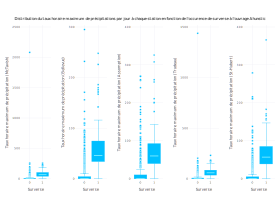

In [53]:
plot_3350_1 = plot(x=df_3350[:, :SURVERSE], y=df_3350[:, :MAXMcTavish], Geom.boxplot, Guide.xticks(ticks=[0, 1]), Guide.xlabel("Surverse"), Guide.ylabel("Taux horaire maximum de précipitation (McTavish)", orientation=:vertical))
plot_3350_2 = plot(x=df_3350[:, :SURVERSE], y=df_3350[:, :MAXBellevue], Geom.boxplot, Guide.xticks(ticks=[0, 1]), Guide.xlabel("Surverse"), Guide.ylabel("Taux horaire maximum de précipitation (Bellevue)", orientation=:vertical))
plot_3350_3 = plot(x=df_3350[:, :SURVERSE], y=df_3350[:, :MAXAssomption], Geom.boxplot, Guide.xticks(ticks=[0, 1]), Guide.xlabel("Surverse"), Guide.ylabel("Taux horaire maximum de précipitation (Assomption)", orientation=:vertical))
plot_3350_4 = plot(x=df_3350[:, :SURVERSE], y=df_3350[:, :MAXPET], Geom.boxplot, Guide.xticks(ticks=[0, 1]), Guide.xlabel("Surverse"), Guide.ylabel("Taux horaire maximum de précipitation (Trudeau)", orientation=:vertical))
plot_3350_5 = plot(x=df_3350[:, :SURVERSE], y=df_3350[:, :MAXStHubert], Geom.boxplot, Guide.xticks(ticks=[0, 1]), Guide.xlabel("Surverse"), Guide.ylabel("Taux horaire maximum de précipitation (St-Hubert)", orientation=:vertical))

title(hstack(plot_3350_1, plot_3350_2, plot_3350_3, plot_3350_4, plot_3350_5), "Distribution du taux horaire maximum de précipitations par jour à chaque station en fonction de l'occurence de surverse à l'ouvrage Ahunstic")

## Analyse de la somme de précipitations sur deux jours

#### Boxplot de la somme sur deux jours des précipitations à chaque station en fonction de l'occurence de surverse à l'ouvrage Pointes-aux-trembles
Ci-dessus la distribution de la somme sur deux jours des précipitations aux différentes stations selon l'occurence ou non de surverse à l'ouvrage 4240 (**Pointes-aux-trembles**). La différence entre les deux distributions pour chaque station suggère que la somme sur deux jours des précipitations observées à chaque station a une influence sur l'occurence des surverses à l'ouvrage 4240.

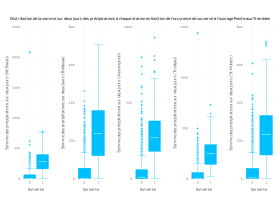

In [59]:
plot_4240_1 = plot(x=df_4240[:, :SURVERSE], y=df_4240[:, :SUM2McTavish], Geom.boxplot, Guide.xticks(ticks=[0, 1]), Guide.xlabel("Surverse"), Guide.ylabel("Somme des précipitations sur deux jours (McTavish)", orientation=:vertical))
plot_4240_2 = plot(x=df_4240[:, :SURVERSE], y=df_4240[:, :SUM2Bellevue], Geom.boxplot, Guide.xticks(ticks=[0, 1]), Guide.xlabel("Surverse"), Guide.ylabel("Somme des précipitations sur deux jours (Bellevue)", orientation=:vertical))
plot_4240_3 = plot(x=df_4240[:, :SURVERSE], y=df_4240[:, :SUM2Assomption], Geom.boxplot, Guide.xticks(ticks=[0, 1]), Guide.xlabel("Surverse"), Guide.ylabel("Somme des précipitations sur deux jours (Assomption)", orientation=:vertical))
plot_4240_4 = plot(x=df_4240[:, :SURVERSE], y=df_4240[:, :SUM2PET], Geom.boxplot, Guide.xticks(ticks=[0, 1]), Guide.xlabel("Surverse"), Guide.ylabel("Somme des précipitations sur deux jours (Trudeau)", orientation=:vertical))
plot_4240_5 = plot(x=df_4240[:, :SURVERSE], y=df_4240[:, :SUM2StHubert], Geom.boxplot, Guide.xticks(ticks=[0, 1]), Guide.xlabel("Surverse"), Guide.ylabel("Somme des précipitations sur deux jours (St-Hubert)", orientation=:vertical))

title(hstack(plot_4240_1, plot_4240_2, plot_4240_3, plot_4240_4, plot_4240_5), "Distribution de la somme sur deux jours des précipitations à chaque station en fonction de l'occurence de surverse à l'ouvrage Pointe-aux-Trembles")

## Analyse du maximum de précipitations tombées en 3 heures à chaque jour.

#### Boxplot du maximum de précipitations tombées en 3 heures à chaque station en fonction de l'occurence de surverse à l'ouvrage Vieux-Montréal
Ci-dessus la distribution du maximum de précipitations tombées en 3 heures aux différentes stations selon l'occurence ou non de surverse à l'ouvrage 4350 (**Vieux-Montréal**). La différence entre les deux distributions pour chaque station suggère que le maximum de précipitations tombées en 3 heures observées à chaque station a une influence sur l'occurence des surverses à l'ouvrage 4350.

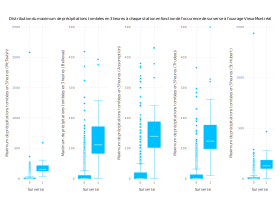

In [81]:
plot_4350_1 = plot(x=df_4350[:, :SURVERSE], y=df_4350[:, :MAX3HMcTavish], Geom.boxplot, Guide.xticks(ticks=[0, 1]), Guide.xlabel("Surverse"), Guide.ylabel("Maximum de précipitations tombées en 3 heures (McTavish)", orientation=:vertical))
plot_4350_2 = plot(x=df_4350[:, :SURVERSE], y=df_4350[:, :MAX3HBellevue], Geom.boxplot, Guide.xticks(ticks=[0, 1]), Guide.xlabel("Surverse"), Guide.ylabel("Maximum de précipitations tombées en 3 heures (Bellevue)", orientation=:vertical))
plot_4350_3 = plot(x=df_4350[:, :SURVERSE], y=df_4350[:, :MAX3HAssomption], Geom.boxplot, Guide.xticks(ticks=[0, 1]), Guide.xlabel("Surverse"), Guide.ylabel("Maximum de précipitations tombées en 3 heures (Assomption)", orientation=:vertical))
plot_4350_4 = plot(x=df_4350[:, :SURVERSE], y=df_4350[:, :MAX3HTrudeau], Geom.boxplot, Guide.xticks(ticks=[0, 1]), Guide.xlabel("Surverse"), Guide.ylabel("Maximum de précipitations tombées en 3 heures (Trudeau)", orientation=:vertical))
plot_4350_5 = plot(x=df_4350[:, :SURVERSE], y=df_4350[:, :MAX3HStHubert], Geom.boxplot, Guide.xticks(ticks=[0, 1]), Guide.xlabel("Surverse"), Guide.ylabel("Maximum de précipitations tombées en 3 heures (St-Hubert)", orientation=:vertical))

title(hstack(plot_4350_1, plot_4350_2, plot_4350_3, plot_4350_4, plot_4350_5), "Distribution du maximum de précipitations tombées en 3 heures à chaque station en fonction de l'occurence de surverse à l'ouvrage Vieux-Montréal")

## Analyse de la moyenne de précipitations journalière.

#### Boxplot de la moyenne de précipitations à chaque station en fonction de l'occurence de surverse à l'ouvrage Verdun
Ci-dessus la distribution de la moyenne des précipitations aux différentes stations selon l'occurence ou non de surverse à l'ouvrage 4380 (**Verdun**). La différence entre les deux distributions pour chaque station suggère que la moyenne de précipitations observées à chaque station a une influence sur l'occurence des surverses à l'ouvrage 4380.

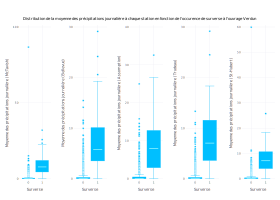

In [90]:
plot_4380_1 = plot(x=df_4380[:, :SURVERSE], y=df_4380[:, :MEANMcTavish], Geom.boxplot, Guide.xticks(ticks=[0, 1]), Guide.xlabel("Surverse"), Guide.ylabel("Moyenne des précipitations journalière (McTavish)", orientation=:vertical))
plot_4380_2 = plot(x=df_4380[:, :SURVERSE], y=df_4380[:, :MEANBellevue], Geom.boxplot, Guide.xticks(ticks=[0, 1]), Guide.xlabel("Surverse"), Guide.ylabel("Moyenne des précipitations journalière (Bellevue)", orientation=:vertical))
plot_4380_3 = plot(x=df_4380[:, :SURVERSE], y=df_4380[:, :MEANAssomption], Geom.boxplot, Guide.xticks(ticks=[0, 1]), Guide.xlabel("Surverse"), Guide.ylabel("Moyenne des précipitations journalière (Assomption)", orientation=:vertical))
plot_4380_4 = plot(x=df_4380[:, :SURVERSE], y=df_4380[:, :MEANTrudeau], Geom.boxplot, Guide.xticks(ticks=[0, 1]), Guide.xlabel("Surverse"), Guide.ylabel("Moyenne des précipitations journalière (Trudeau)", orientation=:vertical))
plot_4380_5 = plot(x=df_4380[:, :SURVERSE], y=df_4380[:, :MEANStHubert], Geom.boxplot, Guide.xticks(ticks=[0, 1]), Guide.xlabel("Surverse"), Guide.ylabel("Moyenne des précipitations journalière (St-Hubert)", orientation=:vertical))

title(hstack(plot_4380_1, plot_4380_2, plot_4380_3, plot_4380_4, plot_4380_5), "Distribution de la moyenne des précipitations journalière à chaque station en fonction de l'occurence de surverse à l'ouvrage Verdun")

# Modèle #1: Classification par Random Forests

### Écrire une description 

In [12]:
"""
getForest permet d'obtenir pour chaque ouvrage un modèle de prédiction basé sur la classification par forêts aléatoires. 
Le paramètre rf_fit_params correspondent aux valeurs possibles des hyperparamètres de RandomForestClassifier

@params
num_ouvrage:      le numéro de l'ouvrage à évaluer
rf_fit_param:     dictionnaire des valeurs possibles pour les hyperparamètres du modèle RF
n_folds:          le nombre de plis à effectuer sur l'ensemble d'entrainement lors de la validation croisée
grid:             false par défaut, si à true, la fonction effectue une GridSearch (exhaustive) sur l'ensemble des
                  hyperparamètres fournis, sinon elle effectue une RandomizedSearch
n_iter:           10 par défaut, le nombre de modèles à essayer lors d'une RandomizedSearch

"""
function getForest(num_ouvrage::String; fit_params::Dict, n_folds = 5, grid=false, n_iter = 1000, verbose=1)
    train = CreateDataframe(num_ouvrage, surverse_df)
    all_X = convert(Matrix{Float64}, train[:, 4:size(train, 2)])
    all_y = train[!, :SURVERSE]
    
    # On doit utiliser la fonction train_test_split de sklearn car notre jeu de données est très désiquilibré.
    # le parametre "stratify" de la fonction permet de parer à ca
    
    X_train, X_test, y_train, y_test = train_test_split(all_X, all_y, test_size=.2, shuffle=true, random_state = 34, stratify=all_y)

    # Préparation de la classification par RandomForests.
    # Les HyperParamètres seront évalués dans la GridSearch/RandomizedSearch
    # StandardScaler() est utilisé pour normaliser les données
    pipe = Pipelines.Pipeline([("ss", StandardScaler()),
                               ("rf", RandomForestClassifier(rng=42))])
    
    n_models = 1
    
    for (k,v) in fit_params
        n_models *= length(v)
    end

    println("Nombre de modèles à parcourir: $(n_models)\n")

    if grid
        M = GridSearch.GridSearchCV(estimator=pipe,
                                    param_grid=fit_params,
                                    cv=n_folds,
                                    verbose=verbose)
    else
        M = GridSearch.RandomizedSearchCV(estimator=pipe,
                                          param_distributions=fit_params,
                                          cv=n_folds,
                                          n_iter=n_iter,
                                          verbose=verbose)
    end

    bon_fit = fit!(M, X_train, y_train)
    println("training score: ", M.best_score_ , '\n', "best parameters: ", M.best_params_,'\n')
    y_true, y_pred = y_test, predict(M, X_test) 
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    println("F1: ", f1)
    println("AUC: ", auc)
    println("test score: ", classification_report(y_true, y_pred))

    return (modele=bon_fit, f1=f1, auc=auc)
end

getForest

In [13]:
"""
getLogitPCA permet d'obtenir pour chaque ouvrage un modèle de prédiction basé sur la régression logistique et l'analyse
en composantes principales. La fonction effectue une grid search sur chacune des configurations possibles proposées
par le dictionnaire des hyoerparamètres fit_params

@params
num_ouvrage:      le numéro de l'ouvrage à évaluer
fit_param:        dictionnaire des valeurs possibles pour les hyperparamètres du modèle de régression logistique
n_folds:          le nombre de plis à effectuer sur l'ensemble d'entrainement lors de la validation croisée

"""

function getLogitPCA(num_ouvrage::String; fit_params::Dict, n_folds=5, verbose=1)
    train = CreateDataframe(num_ouvrage, surverse_df)
    all_X = convert(Matrix{Float64}, train[:, 4:size(train, 2)])
    all_y = train[!, :SURVERSE]
    
    # On doit utiliser la fonction train_test_split de sklearn car notre jeu de données est très déséquilibré.
    # le parametre "stratify" de la fonction permet de parer à ca
    
    X_train, X_test, y_train, y_test = train_test_split(all_X, all_y, test_size=.2, shuffle=true, random_state = 34, stratify=all_y)

    n_models = 1
    
    for (k,v) in fit_params
        n_models *= length(v)
    end

    println("Nombre de modèles à parcourir: $(n_models)\n")
    
    # Préparation du Pipeline à tester.
    # Le Pipeline permet de lier la standardisation des données à l'obtention des composantes principales et à la création 
    # d'une régression logistique les utilisant.
    pipe = Pipelines.Pipeline([("ss", StandardScaler()),
                               ("pca", PCA()),
                               ("lr", LogisticRegression(max_iter=1000, random_state=42))])
    
    M = GridSearch.GridSearchCV(estimator=pipe,
                                param_grid=fit_params,
                                cv=n_folds, 
                                verbose=verbose)

    bon_fit = fit!(M, X_train, y_train)
    println("training score: ", M.best_score_ , '\n', "best parameters: ", M.best_params_,'\n')
    y_true, y_pred = y_test, predict(M, X_test) 
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    println("F1: ", f1)
    println("AUC: ", auc)
    println("test score: ", classification_report(y_true, y_pred))

    return (modele=bon_fit, f1=f1, auc=auc)
end


getLogitPCA (generic function with 1 method)

# Random Forest et RandomizedSearch/GridSearch
## Démarche
#### 1. RandomizedSearch
Nous utilisons la technique de classification par RandomForests. Afin d'optimiser notre modèle, nous devons parcourir l'espace des hyperparamètres du modèle pour n'en garder que les meilleures valeurs: 
1. n_subfeatures: le nombre de variables explicatives à sélectionner aléatoirement pour chacun des arbres composant la forêt
2. n_trees: le nombre d'arbres composant la forêt
3. partial_sampling: la fraction du dataframe d'entrainement sur laquelle entrainer chacun des arbres
4. max_depth: la profondeur maximale de chacun des arbres
5. min_samples_leaf: le nombre minimal de données d'entrainement ("sample") par feuille
6. min_sample_split: le nombre minimal de données d'entrainement requis pour qu'un noeud de l'arbre se sépare en deux autres noeuds

Nous avons tout d'abord exécuté une RandomizedSearch de manière indépendante sur chacun des hyperparamètres en donnant à chaque fois une très grande portée à chaque paramètre. En modifiant ainsi chaque hyperparamètre un à un, nous avons pu réduire progressivement la portée possible de chaque paramètre en observant le score de chaque forêt en fonction du paramètre modifié. 

L'objectif de cette démarche a été de progressivement réduire l'espace des modèles pour pouvoir effectuer une GridSearch à la place d'une RandomizedSearch, et ce, sur l'entièreté des hyperparamètres

#### 2. GridSearch

La GridSearch, contrairement à la RandomizedSearch, permet de passer à travers chacun des modèles proposés, un à un. Comme pour la RandomizedSearch, elle utilise la validation croisée qui aide à réduire le phénomène de surapprentissage, en testant chacun des modèles plusieurs fois (k fois) sur un ensemble de test et d'entrainement différent à chaque fois.

In [14]:
ouvrage = ["3260-01D", "3350-07D", "4240-01D", "4350-01D", "4380-01D"]
best_models_rf = Dict()

#Préparation d'un dictionnaire de paramètres pour l'optimisation des hyperparamètres du modèle
#On déclare les valeurs jugées possibles pour le modèle

rf_fit_params = Dict()
rf_fit_params["rf__n_subfeatures"] = 3:1:10 
rf_fit_params["rf__n_trees"] = 80:20:500
rf_fit_params["rf__partial_sampling"] = [0.6, 0.7, 0.8]
rf_fit_params["rf__max_depth"] = 3:2:50
rf_fit_params["rf__min_samples_leaf"] = 5:2:10
rf_fit_params["rf__min_samples_split"] = 2:2:16
rf_fit_params["rf__min_purity_increase"] = [0.0, 0.1, 0.2]

for i=1:length(ouvrage)
    @time best_models_rf[ouvrage[i]] = getForest(ouvrage[i],
                                              fit_params = rf_fit_params,
                                              n_iter=2000)
    println("Accuracy score: ", best_models_rf[ouvrage[i]].modele.best_score_, "\n")

    println(ouvrage[i], " done")
    println(" ******************************* ")
    println(" ******************************* ")
end


Nombre de modèles à parcourir: 912384

Fitting 5 folds for each of 2000 candidates, totalling 10000 fits
training score: 0.9532497149372862
best parameters: Dict{Symbol,Any}(:rf__min_samples_leaf => 9,:rf__n_trees => 300,:rf__min_samples_split => 16,:rf__min_purity_increase => 0.1,:rf__n_subfeatures => 3,:rf__max_depth => 15,:rf__partial_sampling => 0.6)

F1: 0.7333333333333334
AUC: 0.7894736842105263
test score:               precision    recall  f1-score   support

           0       0.96      1.00      0.98       201
           1       1.00      0.58      0.73        19

    accuracy                           0.96       220
   macro avg       0.98      0.79      0.86       220
weighted avg       0.97      0.96      0.96       220

837.451842 seconds (291.73 M allocations: 451.058 GiB, 57.24% gc time)
Accuracy score: 0.9532497149372862

3260-01D done
 ******************************* 
 ******************************* 
Nombre de modèles à parcourir: 912384

Fitting 5 folds for each of 

In [15]:
lr_fit_params = Dict()
lr_fit_params["lr__C"] = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]#exp10.(-4: 1: 1)
lr_fit_params["pca__n_components"] = 2:1:20

ouvrage = ["3260-01D", "3350-07D", "4240-01D", "4350-01D", "4380-01D"]
best_models_lr = Dict()

for i=1:length(ouvrage)
    @time best_models_lr[ouvrage[i]] = getLogitPCA(ouvrage[i], fit_params=lr_fit_params)
    println("Accuracy score: ", best_models_lr[ouvrage[i]].modele.best_score_, "\n")
    
    println(ouvrage[i], " done\n")
    println(" ******************************* ")
    println(" ******************************* ")
end


Nombre de modèles à parcourir: 114

Fitting 5 folds for each of 114 candidates, totalling 570 fits
training score: 0.9521094640820981
best parameters: Dict{Symbol,Any}(:lr__C => 1.0,:pca__n_components => 9)

F1: 0.8571428571428572
AUC: 0.8922492799162084
test score:               precision    recall  f1-score   support

           0       0.98      1.00      0.99       201
           1       0.94      0.79      0.86        19

    accuracy                           0.98       220
   macro avg       0.96      0.89      0.92       220
weighted avg       0.98      0.98      0.98       220

  8.353451 seconds (3.41 M allocations: 521.900 MiB)
Accuracy score: 0.9521094640820981

3260-01D done

 ******************************* 
 ******************************* 
Nombre de modèles à parcourir: 114

Fitting 5 folds for each of 114 candidates, totalling 570 fits
training score: 0.9210977701543739
best parameters: Dict{Symbol,Any}(:lr__C => 10.0,:pca__n_components => 3)

F1: 0.8524590163934426
AU

In [102]:
# On choisit maintenant, pour chacun des ouvrages, le modèle ayant le meilleur score f1 entre la RandomForest et la 
# régression logistique

best_models = Dict()

for (ouvrage, m) in best_models_rf
    if m.f1 > best_models_lr[ouvrage].f1
        best_models[ouvrage] = m.modele
        println(ouvrage, " => F1: ", m.f1, ", AUC: ", m.auc)
    else
        best_models[ouvrage] = best_models_lr[ouvrage].modele
        println(ouvrage, " => F1: ", best_models_lr[ouvrage].f1, ", AUC: ", best_models_lr[ouvrage].auc)
    end
end
#best_models = best_models_rf
best_models

UndefVarError: UndefVarError: best_models_rf not defined

# Création du fichier de prédictions pour soumettre sur Kaggle

Dans ce cas-ci, nous prédirons une surverse avec une probabilité de 1/2 sans considérer aucune variable explicative.

In [100]:
"""
getVarEx retourne une ligne de toutes les variables explicatives pour une journée donnée.

@params
date: date de la journée pour laquelle on veut les variables explicatives
total_row: ligne de dataframe contenant toutes les variables explicatives pour la journée demandée.
"""

function getVarEx(date::Date)
    row_sum = filter(row-> row.date== date, X_pcp_sum)
    row_sum_2_days = filter(row-> row.date== date, X_pcp_two_days)
    row_max = filter(row-> row.date== date, X_pcp_max)
    row_max_3h = filter(row->row.date== date, X_max_three_hours)
    row_mean = filter(row->row.date== date, X_pcp_mean)
    row_median = filter(row->row.date== date, X_pcp_median)

    total_row = join(row_sum, row_sum_2_days, on = :date)
    total_row = join(total_row, row_max, on = :date)
    total_row = join(total_row, row_max_3h, on = :date)
    total_row = join(total_row, row_mean, on = :date)
    total_row = join(total_row, row_median, on = :date)

    return total_row
end

getVarEx (generic function with 1 method)

In [101]:
"""
dfRowTo2D prend une ligne de dataframe et retourne un tableau 2 dimensions contenant les mêmes données.

@params
row: la ligne de DataFrame à convertir en tableau 2D.
X: tableau 2D contenant les données de la ligne passée en paramètre.
"""

function dfRowTo2D(row::DataFrameRow)
    X = Array{Float64, 2}(undef, 1, length(row))
    for i=1:length(row)
        X[1, i] = row[i]
    end
    return X
end

dfRowTo2D (generic function with 1 method)

In [20]:
## Chargement du fichier de test
test = CSV.read("data/test.csv")
hcat(test, DataFrame(SURVERSE=zeros(Int64, length(test[:,1]))))
rename!(test, :DATE => :date)

## Dataframe des dates et ouvrages à prédire avec toutes les variables explicatives
df_test = getVarEx(test[1, :date])
for i=2:length(test[:,1])
    push!(df_test, convert(Array, getVarEx(test[i, :date])))
end
insert!(df_test, 1, test[:, :NO_OUVRAGE], :NO_OUVRAGE)
insert!(df_test, 3, zeros(Int64, length(df_test[:,1])), :surverse)
#insert!(df_test, 4, ones(Float64, length(df_test[:,1])), :x1)
ambig = []
## Calcul de la probabilité de surverse
for i=1:length(df_test[:,1])
    M = best_models[df_test[i, :NO_OUVRAGE]]
    Exp = dfRowTo2D(df_test[i, 4:size(df_test, 2)])
    proba = predict_proba(M, Exp)
    prediction = predict(M, Exp)
    ouvr = "$(df_test[i, :NO_OUVRAGE])  on  $(df_test[i, :date])"
    if all(i -> i < 0.65, proba) #On print les jours ambiguës
        #push!(ambig, (ouvr, proba))
        println(ouvr)
        println(proba)
        println(prediction, "\n")
    end
    
    df_test[i, :surverse] = prediction[1]
end
#println(ambig)
# Création du fichier sampleSubmission.csv pour soumettre sur Kaggle
ID = test[:,:NO_OUVRAGE].*"_".*string.(test[:,:date])
sampleSubmission = DataFrame(ID = ID, Surverse=df_test[:,:surverse])
CSV.write("sampleSubmission_with_5_variables_rfpca_rand_new_2000iter.csv",sampleSubmission)

# Vous pouvez par la suite déposer le fichier sampleSubmission.csv sur Kaggle.

3350-07D  on  2019-05-01
[0.3960998849578461 0.6039001150421539]
[1]

3350-07D  on  2019-05-19
[0.3522806771989553 0.6477193228010447]
[1]

3350-07D  on  2019-05-20
[0.6143603916849492 0.3856396083150508]
[0]

4240-01D  on  2019-05-23
[0.5954545454545455 0.40454545454545454]
[0]

3350-07D  on  2019-06-14
[0.4515954125202575 0.5484045874797425]
[1]

┌ Warning: `insert!(df::DataFrame, col_ind::Int, item, name::Symbol; makeunique::Bool=false)` is deprecated, use `insertcols!(df, col_ind, name => item; makeunique=makeunique)` instead.
│   caller = top-level scope at In[20]:11
└ @ Core In[20]:11
┌ Warning: `insert!(df::DataFrame, col_ind::Int, item, name::Symbol; makeunique::Bool=false)` is deprecated, use `insertcols!(df, col_ind, name => item; makeunique=makeunique)` instead.
│   caller = top-level scope at In[20]:12
└ @ Core In[20]:12




4240-01D  on  2019-06-11
[0.5318181818181819 0.4681818181818182]
[0]

4350-01D  on  2019-06-11
[0.45 0.55]
[1]

4380-01D  on  2019-06-20
[0.5520119813348824 0.4479880186651176]
[0]

3350-07D  on  2019-07-21
[0.6382600162150824 0.36173998378491756]
[0]

3260-01D  on  2019-08-28
[0.6117789213195346 0.38822107868046535]
[0]

3350-07D  on  2019-09-28
[0.5915540321631567 0.4084459678368432]
[0]

4240-01D  on  2019-09-04
[0.5772727272727273 0.42272727272727273]
[0]

4350-01D  on  2019-09-02
[0.36176470588235293 0.638235294117647]
[1]

4350-01D  on  2019-09-04
[0.5705882352941176 0.4294117647058823]
[0]



"sampleSubmission_with_5_variables_rfpca_rand_new_2000iter.csv"